In [34]:
import nglui
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

read in the soma table to get IDs of cells with cell bodies in volume

In [35]:
soma_df = pd.read_csv('../soma_valence_v185.csv')

In [36]:
soma_df.head()

,id,cell_type,pt_position,pt_root_id,soma_x_nm,soma_y_nm,soma_z_nm,found
0,17,e,[103860 44385 891],648518346349540057,415440,415440,4154400,1
1,453,e,[84054 50604 1424],648518346349538466,336216,336216,3362160,1
2,35,e,[103728 54333 304],648518346349538711,414912,414912,4149120,1
3,74,e,[51543 57568 155],648518346349538715,206172,206172,2061720,1
4,231,e,[77197 61773 428],648518346349537038,308788,308788,3087880,1


read in the synapse table 

In [37]:
syn_df = pd.read_csv('../pni_synapses_v185.csv')

It has 3.2 million rows

In [38]:
print(syn_df.shape)

(3239275, 16)


In [39]:
syn_df.head()

,id,pre_root_id,post_root_id,cleft_vx,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx
0,2715757,648518346349538285,648518346349536759,1103,280784,261896,40600,70050,65534,1015,70196,65474,1015,70104,65602,1015
1,12498,648518346342404863,648518346342414574,62,365832,292808,25800,91472,73196,645,91458,73202,645,91396,73216,645
2,12500,648518346342921567,648518346345323296,62,229144,155952,48080,57250,39028,1202,57286,38988,1202,57312,38966,1203
3,12517,648518346342796822,648518346349537255,955,398452,208560,50760,99538,52184,1276,99613,52140,1269,99550,52098,1276
4,12503,648518346342800412,648518346348190542,718,461868,245212,53560,115462,61350,1335,115467,61303,1339,115468,61296,1335


Lets filter for IDs with somas that are neurons

In [40]:
neuron_df=soma_df.query('cell_type == "i" | cell_type=="e"')

Use this list of IDs to filter all synapses to just those onto neurons 

In [41]:
post_neuron_syn_df=syn_df[syn_df.post_root_id.isin(neuron_df.pt_root_id)]

951,457 of 3.5 million synapses are onto cells with somas in the volume

In [42]:
post_neuron_syn_df.shape

(951457, 16)

Lets summarize the number of inputs these cells have

In [43]:
in_degree_df = post_neuron_syn_df.groupby('post_root_id').post_root_id.count()

In [44]:
in_degree_df.head()

post_root_id
648518346349477331     494
648518346349487432     434
648518346349487752     783
648518346349488919    2626
648518346349489861    1841
Name: post_root_id, dtype: int64

Let's find the cell with the most inputs

In [45]:
max_input_neuron=in_degree_df.index[in_degree_df.argmax()]
print(max_input_neuron)

648518346349538440


it has 5369 input synapses

In [46]:
in_degree_df[max_input_neuron]

5369

Lets filter synapses to just those onto this one neuron

In [47]:
onto_cell_syn_df = post_neuron_syn_df.query(f'post_root_id == {max_input_neuron}').copy()

This illustrates how to setup a nglui pipeline to highlight synapses

In [48]:
from nglui.statebuilder import *
# get sources from the neuroglancer link
img_source = "precomputed://https://storage.googleapis.com/microns_public_datasets/pinky100_v0/son_of_alignment_v15_rechunked"
seg_source = "precomputed://gs://microns_public_datasets/pinky100_v185/seg"

# use nglui (www.github.com/seung-lab/NeuroglancerAnnotationUI) to setup a dataframe > neuroglancer link pipeline
img_layer = ImageLayerConfig(name='layer23',
                             source=img_source,
                             )
# we want the segmentation layer with our target neuron always on
seg_layer = SegmentationLayerConfig(name = 'seg',
                                    source = seg_source,
                                    fixed_ids=[max_input_neuron])

# need to consolidate the synapse position into a single column
onto_cell_syn_df.loc[:, 'ctr_pos']=onto_cell_syn_df.apply(lambda x: [x.ctr_pos_x_vx, x.ctr_pos_y_vx, x.ctr_pos_z_vx], axis=1).copy()

# setup a mapping rule for point annotations
syn_points = PointMapper(point_column='ctr_pos', linked_segmentation_column='pre_root_id')
# add these points linked to the segmentation layer name
syn_layer = AnnotationLayerConfig(name='synapses', mapping_rules=syn_points, linked_segmentation_layer='seg')


When you click the below link, you'll be taken to a neuroglancer visualization of the dataset.

If you are unfamiliar with basic neuroglancer visualization, you should read a guide here (https://microns-explorer.org/visualization)

There is also a fast intro (with movies!) written up here https://blog.eyewire.org/explore-cortical-neurons/.

In this view, this code has setup a new layer (synapses).  It should open with the synapse layer details on the right hand side, where you can see a list of synapses.  To learn more about how to interact with this neuroglancer link , you can watch this below 5 minute video. 

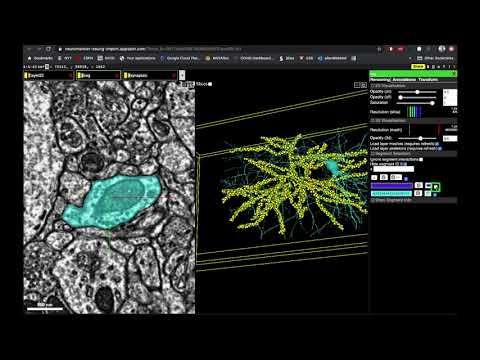

In [49]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('YTbu6vMljuE', width=800, height=600)

setup a state builder with this layer pipeline

then render the state pipeline with the dataframe data

returning the link as an html link

In [50]:
sb = StateBuilder([img_layer, seg_layer, syn_layer])
sb.render_state(onto_cell_syn_df, return_as='html')

Lets repeat the exercise to find cells with the most outputs

In [51]:
pre_neuron_syn_df = syn_df[syn_df.pre_root_id.isin(neuron_df.pt_root_id)]
out_degree_df = pre_neuron_syn_df.groupby('pre_root_id').post_root_id.count()


in contrast to inputs only 15,884 outputs of the

3.2 million synapses can be connected

to cells with cell bodies in volume

In [52]:
pre_neuron_syn_df.shape

(15884, 16)

since we have the data, lets make a dataframe with all the cells in degree
and out degree

In [53]:
in_out_df = pd.DataFrame({'in_degree': in_degree_df, 'out_degree':out_degree_df})

merge in the cell type information we have on these cells

In [54]:
in_out_ct_df = pd.merge(in_out_df, soma_df[['cell_type','pt_root_id']], left_index=True, right_on='pt_root_id' )

you can see here that many cells have low out-degree 
as excitatory neurons in the bottom half of the dataset
have axons which leave the bottom of the volume
before branching, but there are 5 inhibitory neurons with >300 synapses

the in degree varies from a few hundred to >5000 depending on how much
dendrite is in the volume


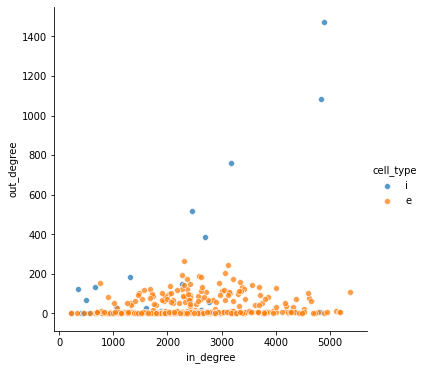

In [55]:
pg=sns.pairplot(x_vars=['in_degree'], y_vars=['out_degree'],
             data=in_out_ct_df, hue='cell_type', plot_kws={'alpha': 0.75},  height=5)


In [56]:
in_out_ct_df.query('out_degree>300')

,in_degree,out_degree,cell_type,pt_root_id
319,4831,1082.0,i,648518346349528994
315,2459,516.0,i,648518346349538179
175,2698,386.0,i,648518346349538791
340,4891,1475.0,i,648518346349539215
185,3172,761.0,i,648518346349539846


let's get all these synapses from these neurons

In [57]:
is_from_most_out = pre_neuron_syn_df.pre_root_id.isin(in_out_ct_df.query('out_degree>300').pt_root_id.values)
most_inh_syn_out = pre_neuron_syn_df[is_from_most_out].copy()

here are our 4220 synapses

In [58]:
most_inh_syn_out.shape

(4220, 16)

lets visualize them all in neuroglancer

In [59]:
most_inh_syn_out['ctr_pos']=most_inh_syn_out.apply(lambda x: [x.ctr_pos_x_vx, x.ctr_pos_y_vx, x.ctr_pos_z_vx], axis=1).values

seg_layer = SegmentationLayerConfig(name = 'seg',
                                    source = seg_source,
                                    selected_ids_column='pre_root_id')

# setup a mapping rule for point annotations
syn_points = PointMapper(point_column='ctr_pos', linked_segmentation_column='post_root_id')
# add these points linked to the segmentation layer name
syn_layer = AnnotationLayerConfig(name='synapses', mapping_rules=syn_points, linked_segmentation_layer='seg')

sb = StateBuilder([img_layer, seg_layer, syn_layer])
# returning the link as an html link
sb.render_state(most_inh_syn_out, return_as='html')

maybe that's a bit overwhelming... lets cut the dataframe to just the cell with the most
outputs, it's a basket cell, check out how many times it makes multiple synapses 
with the same target, you can quickly get a sense for how it distributes its 
outputs across different post-synaptic target structures.

In [60]:
sb.render_state(most_inh_syn_out.query('pre_root_id == 648518346349539215'), return_as='html')